In [5]:
import pandas as pd
import numpy as np
import itertools
import random
import ast
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon, friedmanchisquare, kendalltau, pearsonr
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from pyxdameraulevenshtein import damerau_levenshtein_distance

pd.set_option('display.max_rows', 500)

### Prepare Data

In [6]:
# read data

df = pd.read_csv('all_task_environments.csv', header=0, skiprows=[1])

### Define functions for prediction

In [7]:
def predict_sequence(objects, coordinates, start_coordinates, c, k, dimension=[3,]):
    ''' Predicts sequence based on required objects, object coordinates, start coordinates of subject,
        parameters (c+k) and dimensionality.
        Input: Objects, object coordinates, start coordinates, c, k, dimension
        Output: Sequence of objects as str
    '''
    prediction = []
    possible_items = dict.fromkeys(objects, 0) # generate dict from object list
    coord_index = 0
    start_coords = start_coordinates
    coords = coordinates
    new_coords = {}
    new_start_coords = []
    
    if dimension[0] == 3: # no changes if 3D
        new_coords = coords
        new_start_coords = start_coords
        
    elif dimension[0] == 2: # 2D: remove obsolete coordinate
        if dimension[1] == 'xy':
            new_coords = {key: value[:-1] for key, value in coords.items()}
            new_start_coords = [x[:-1] for x in start_coords]
                
        elif dimension[1] == 'xz':
            new_start_coords = [[x[0], x[-1]] for x in start_coords]
            
            for key, value in coords.items():
                new_value = (value[0], value[-1])
                new_coords[key] = new_value
        
        elif dimension[1] == 'yz':
            new_coords = {key: value[1:] for key, value in coords.items()}
            new_start_coords = [x[1:] for x in start_coords]
                
    elif dimension[0] == 1: # 1D: choose appropriate coordinate
        if dimension[1] == 'x':
            new_coords = {key: value[0] for key, value in coords.items()}
            new_start_coords = [x[0] for x in start_coords]
        
        elif dimension[1] == 'y':
            new_coords = {key: value[1] for key, value in coords.items()}
            new_start_coords = [x[1] for x in start_coords]
        
        elif dimension[1] == 'z':
            new_coords = {key: value[2] for key, value in coords.items()}
            new_start_coords = [x[2] for x in start_coords]
    
    while bool(possible_items) == True: # while dict not empty
        for obj in possible_items.keys():
            possible_items[obj] = ((distance.euclidean(
                                new_start_coords[coord_index], 
                                new_coords[obj])
                                ) ** k[obj]) * c[obj]
        #print(possible_items)                      
        minval = min(possible_items.values())
        minval = [k for k, v in possible_items.items() if v == minval]
        minval = random.choice(minval) # choose prediction randomly if multiple items have same cost
        prediction.append(minval)
        del possible_items[minval]
        coord_index += 1
        
    return prediction

In [28]:
def get_average(objects, coordinates, start_coordinates, c, k, dimension, sequence):
    ''' Returns average edit distance (Damerau-Levenshtein) for 100 trials of sequence prediction.
    '''
    edit_list = []
    prediction_list = []

    for x in range(0,100):
        result = ''.join(predict_sequence(objects, coordinates, start_coordinates, c, k, dimension))
        dl = damerau_levenshtein_distance(sequence,result) / len(sequence)
        edit_list.append(dl)
        prediction_list.append(result)
    
    avg = np.mean(edit_list)
    return avg, prediction_list, edit_list

In [29]:
def get_avg_editdist(data):
    ''' Calculates average edit distance for all combinations of parameters (c, k, dimension).
        Input: Dataframe with objects, coordinates, start coordinates, object categories
        Output: Dataframe with edit distance results (col name: parameters used)
    '''
    results = pd.DataFrame()
    dimensions = [[3,'xyz']]
    predictions = {}
    edit_distances = {}
        
    for row in range(0,len(df)):
        objects = list(df.at[row,'objects'].split(','))
        strong_k = list(df.at[row,'strong_k'].split(','))
        mid_k = list(df.at[row,'mid_k'].split(','))
        coordinates = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in df.at[row,'coordinates'].split(';'))}
        start_coordinates = list(ast.literal_eval(df.at[row, 'start_coordinates']))
        sequence = str(df.at[row,'sequence'])
        
        for k in np.arange(0.6,0.7,0.1):
            k_strong = round(k,2)
            k_mid = round(k + 0.1,2)
            k1 = {obj: k_strong if obj in strong_k else k_mid if obj in mid_k else 1.0 for obj in objects}
                    
            for c in np.arange(1.8,1.9,0.1):
                c = round(c, 1)
                c1 = {obj: c if obj in df.at[row, 'containment'] else 1.0 for obj in objects}
                
                for dim in dimensions:                
                    # get average edit distance
                    edit_dist, predictions[sequence], edit_distances[sequence] = get_average(objects, coordinates, start_coordinates, c1, k1, dim, sequence)
                    edit_dist = edit_dist / len(sequence)
                    
                    params = 'c: ' + str(c) + '; k: ' + str(k_strong) + ',' + str(k_mid) + '; ' + str(dim[1])
                    results.at[row,params] = edit_dist
                    
    return results, predictions, edit_distances

### Calculate edit distances, create df

In [30]:
#%%timeit -n1 -r1
results_new, predictions, edit_distances = get_avg_editdist(df)

In [31]:
predictions

{'tnpsc': ['tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
  'tnpsc',
 

In [67]:
len(edit_distances.keys())

23

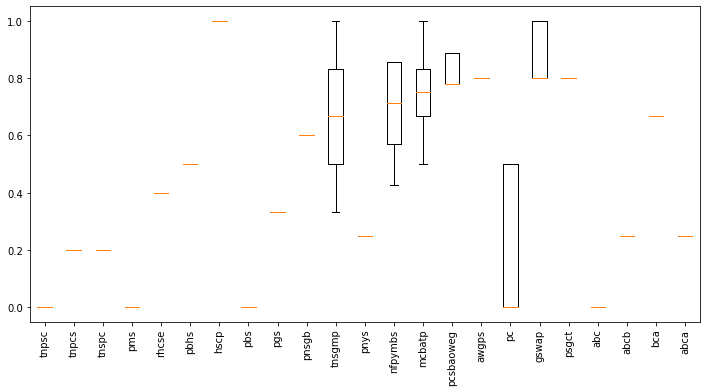

In [69]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

for dist in edit_distances.keys():
    ax.boxplot(edit_distances.values(), notch=False)
    
plt.xticks(range(1,24), labels=edit_distances.keys(), rotation=90)
plt.yticks(np.arange(0.0,1.1,0.2))
plt.margins(0.05)
plt.subplots_adjust(bottom=0.15)